## Getting up Vizdoom running 

In [6]:
#VIZDOOM allows developing AI bots that play DOOM using visual information

In [2]:
# Import vizdoom for game env
from vizdoom import *                          #import all vizdoom dependency
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

## Setting up the game

In [2]:
game =DoomGame()       #creating an instance from vizdoom class
game.load_config('github/VizDoom/scenarios/deadly_corridor_S1.cfg')      #this config allows to load owr reward,buttons etc
game.init()            #stariting it up

In [3]:
#set of actions we can take in the environment
actions=np.identity(7,dtype=np.uint8)

In [4]:
random.choice(actions)


array([0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [26]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()                       #using get state function of the game instance
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - health
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)    #4 as we want to skip 4 frames
        # Print reward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: 0.0
reward: -7.1104888916015625
reward: -8.734405517578125
reward: -0.1011199951171875
reward: -0.0518341064453125
reward: 0.0
reward: 0.0
reward: -7.62939453125e-05
reward: 0.0
reward: 0.0
reward: -0.0013885498046875
reward: 7.110260009765625
reward: 8.529800415039062
reward: 5.7534027099609375
reward: -3.1796112060546875
reward: -5.0216522216796875
reward: -10.01129150390625
reward: -3.1761627197265625
reward: 7.06011962890625
reward: 8.469589233398438
reward: 12.772933959960938
reward: 11.492279052734375
reward: -0.3734588623046875
reward: -4.4556884765625
reward: -2.6354522705078125
reward: 5.6484375
reward: 3.655914306640625
reward: -4.652435302734375
reward: 0.239776611328125
reward: 3.8973236083984375
reward: 2.6287078857421875
reward: -4.0460662841796875
reward: 3.68084716796875
reward: 6.2183990478515625
reward: -2.865264892578125
reward: -5.6400299072265625
reward: -3.8043975830078125
reward: -2.78558349609375
reward: -2.4213104248046875
reward: -1.6332855

KeyboardInterrupt: 

In [15]:
game.new_episode()

In [16]:
state = game.get_state()

In [17]:
state

In [18]:
 state.screen_buffer                     #gives the image

array([[[55, 55, 55, ..., 55, 55, 47],
        [55, 55, 55, ..., 31, 31, 47],
        [55, 55, 55, ..., 31, 31, 47],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 35, 35, ..., 35, 35, 27],
        [35, 35, 35, ..., 23, 23, 27],
        [35, 35, 35, ..., 23, 23, 27],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[19, 19, 19, ..., 19, 19, 11],
        [19, 19, 19, ..., 11, 11, 11],
        [19, 19, 19, ..., 11, 11, 11],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], dtype=uint8)

In [19]:
info = state.game_variables           #health is out state variable

In [20]:
info

array([100.])

In [5]:
game.close()

## Converting it to Gym Environment

In [3]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [4]:
class VizDOOMGym(Env):
    #This is the first function that is called when we start the environment
    
    def __init__(self,render=False,config='github/VizDoom/scenarios/deadly_corridor_S1.cfg'):
        super().__init__()           #inheriting for Env class
        #set up the game
        self.game =DoomGame()       #creating an instance from vizdoom class
        self.game.load_config(config)      #this config allows to load owr reward,buttons etc
        
        #Render form logic
        if render==False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
            
        self.game.init()            #stariting it up
        
        #Creating the action and environment space
        self.observation_space=Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space=Discrete(7)
        
        #Extra game variables
        self.damage_taken=0
        self.hitcount=0
        self.ammo=52
        
     
    #This is how we take a step in an environment
    def step(self,action):
        actions=np.identity(7,dtype=np.uint8)
        movement_reward=self.game.make_action(actions[action],4)
        reward=0 
        #all other stuff
        if self.game.get_state():
            state=self.game.get_state().screen_buffer               #to avoid error if there is no state at end
            state=self.grayscale(state)
            
            #Game variables
            game_variables=self.game.get_state().game_variables
            health,damage_taken,hitcount,ammo=game_variables
            
            #Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200  + ammo_delta*5 
            info = ammo
            
            
        else:
            state = np.zeros(self.observation_space.shape)
            info=0
        info = {"info":info}
        
        
        done=self.game.is_episode_finished()
        
        
        return state,reward,done,info
    
    #Defining how to render the environment
    def render():
        pass
    #This is what happens when we restart the game
    def reset(self):
        self.game.new_episode()
        state=self.game.get_state().screen_buffer
        return self.grayscale(state)
    #Grayscalling the image
    
    def grayscale(self, observation):
            
        	gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        	resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        	state = np.reshape(resize, (100,160,1))
        	return state   
    def close(self):
        self.game.close()
        
        
        

In [8]:
env=VizDOOMGym()

In [30]:
env.step

<bound method VizDOOMGym.step of <__main__.VizDOOMGym object at 0x000001BF0AA42EF0>>

In [31]:
state=env.reset()

In [32]:
env.step(1)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 -40.0,
 False,
 {'info': 52.0})

In [21]:
state.shape

(100, 160, 1)

## View Environment

In [34]:
from matplotlib import pyplot as plt

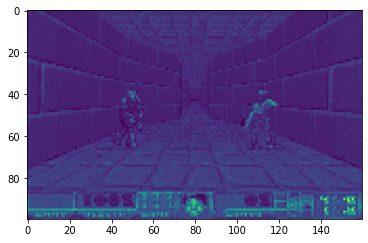

In [35]:
plt.imshow(state)

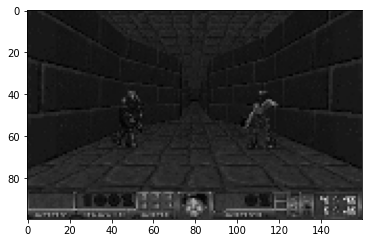

In [36]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [9]:
env.close()

## Environment checker

In [5]:
from stable_baselines3.common import env_checker

In [111]:
env=VizDOOMGym()

In [112]:
env_checker.check_env(env)             #will show if there is any error in the environment

In [113]:
env.close()

## Setup Callback

In [6]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [7]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [8]:
CHECKPOINT_DIR = './train/train_corridor2'
LOG_DIR = './logs/log_corridor2'

In [9]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## Train Model using Curriculum 


In [10]:
from stable_baselines3 import PPO

In [14]:
env=VizDOOMGym(config='github/VizDoom/scenarios/deadly_corridor_S5.cfg')

In [15]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192,clip_range=0.1,gamma=0.95,gae_lambda=0.9)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [16]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [18]:
model.learn(total_timesteps=50000,callback=callback)

Logging to ./logs/log_corridor2\PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.4     |
|    ep_rew_mean     | 18.8     |
| time/              |          |
|    fps             | 13       |
|    iterations      | 1        |
|    time_elapsed    | 609      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36.2         |
|    ep_rew_mean          | 28.1         |
| time/                   |              |
|    fps                  | 10           |
|    iterations           | 2            |
|    time_elapsed         | 1515         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0022919807 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_varia

In [19]:
PPO_PATH=os.path.join('train','train_coridor2_','S_save')
model.save(PPO_PATH)
del model
env.close()

In [21]:
from stable_baselines3.common.evaluation import evaluate_policy

In [25]:
PPO_PATH=os.path.join('train','train_coridor2_','S_save')
model=PPO.load(PPO_PATH)
env=VizDOOMGym(config='github/VizDoom/scenarios/deadly_corridor_S5.cfg')
model.set_env(env)
mean_reward,_=evaluate_policy(model,env,n_eval_episodes=10)
print(mean_reward)
env.close()
del model

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
-102.45140838623047


## Average mean_mean reward of -102.45